# Preparando o ambiente 

In [168]:
from math import sqrt
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import pandas_profiling
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift
from sklearn.mixture import BayesianGaussianMixture
from itertools import cycle

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.max_rows = 999

In [169]:
df_mkt = pd.read_csv('../data/estaticos_market.csv')

# Limpeza dos dados

## Remoção por dados faltantes

In [170]:
df_mkt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462298 entries, 0 to 462297
Columns: 182 entries, Unnamed: 0 to qt_filiais
dtypes: bool(9), float64(144), int64(2), object(27)
memory usage: 614.1+ MB


In [171]:
df = pd.DataFrame(df_mkt.isna().sum() / df_mkt.shape[0], columns=['per_na'])
df_ = df[df['per_na'] > 0.5]

In [172]:
columns_to_drop = list(df_.transpose().columns)
columns_to_drop.append('Unnamed: 0')


df_mkt_dropped = df_mkt.drop(columns=columns_to_drop)

## Remoção das variáveis por significado em relação ao contexto

In [173]:
df_mkt_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462298 entries, 0 to 462297
Data columns (total 50 columns):
id                                       462298 non-null object
fl_matriz                                462298 non-null bool
de_natureza_juridica                     462298 non-null object
sg_uf                                    462298 non-null object
natureza_juridica_macro                  462298 non-null object
de_ramo                                  462298 non-null object
setor                                    460371 non-null object
idade_empresa_anos                       462298 non-null float64
idade_emp_cat                            462298 non-null object
fl_me                                    462298 non-null bool
fl_sa                                    462298 non-null bool
fl_epp                                   462298 non-null bool
fl_mei                                   462298 non-null bool
fl_ltda                                  462298 non-null bool
dt_s

In [174]:
columns_to_drop = [
    'fl_email', 'fl_telefone', 'fl_matriz', 'sg_uf_matriz', 'nm_segmento', 'de_ramo', 'idade_empresa_anos', 'dt_situacao', 'fl_sa', 'fl_mei',
    'fl_me', 'fl_epp', 'fl_ltda', 'fl_st_especial', 'fl_spa', 'fl_optante_simei', 'fl_simples_irregular', 'idade_maxima_socios',
    'de_natureza_juridica', 'de_faixa_faturamento_estimado', 'vl_faturamento_estimado_aux', 'vl_faturamento_estimado_grupo_aux', 'fl_veiculo', 
    'vl_total_veiculos_pesados_grupo', 'vl_total_veiculos_leves_grupo', 'fl_antt', 'nm_divisao', 'nm_meso_regiao', 'nm_micro_regiao', 
    'qt_socios_pf', 'qt_socios_pj', 'idade_media_socios', 'empsetorcensitariofaixarendapopulacao', 'fl_passivel_iss', 'idade_minima_socios', 
    'qt_socios_st_regular', 'qt_socios', 'de_saude_rescencia', 'nu_meses_rescencia', 'qt_filiais', 'fl_optante_simples'
]

df_mkt_dropped_intuition = df_mkt_dropped.drop(columns=columns_to_drop)

### Explicando as variáveis removidas

- ### `fl_email`:  boolean value, true if the company has a phone number registered in IRS database. 
  - Acreditamos não ser uma variável de alta relevância para o contexto do problema
- ### `fl_telefone`: boolean value, true if the cnpj has an email registered at the IRF database
  - Acreditamos não ser uma variável de alta relevância para o contexto do problema
- ### `fl_matriz`: boolean value, true if the CNPJ corresponds to the "matriz". 
  - ~93% dos dos registros eram matriz
- ### `sg_uf_matriz`: character, state of the main office location
  - Sendo que ~93% dos dados correspondem a matriz, esta informação não agrega muito sendo que temos dados de localização
- ### `nm_segmento`: character, name description of the primary economic activity cluster of the company
  - Acreditamos ser uma variável relevante porém existem outros dados que representam a atividade econômica de uma maneira mais abrangente i.e. setor, o qual mantemos no dataset
- ### `de_ramo`: description of a macro activity category/branch based on the CNAE code
  - Mesma análise da variável anterior
- ### `nm_divisao`: character, name description of the primary economic activity of the company
  - Mesma análise da variável anterior
- ### `idade_empresa_anos`: numeric value, age of the company.
  - Optamos por uma variável mais abrangente i.e. `idade_emp_cat`, que representa a idade da empresa em intervalos
- ### `dt_situacao`: date when the "de_situacao" was registered by the IRS.
  - Acreditamos não ser uma variável de alta relevância para o contexto do problema
- ### `fl_sa`: boolean value, true if the company has the term 'SA' in the end of its legal name.
  - Esta variável pode representar o tamanho da empresa, porém optamos pela variável `de_faixa_faturamento_estimado_grupo`, que pode representar o tamanho da empresa de uma maneira mais precisa.  Além disso, 98% é falso
- ### `fl_mei`: boolean value, true if the company has the term 'MEI' in the end of its legal name
  - Mesma análise da variável anterior
- ### `fl_me`: boolean value, true if the company has the term 'ME' in the end of its legal name
  - Mesma análise da variável anterior
- ### `fl_epp`: boolean value, true if the company has the term 'EPP' in the end of its legal name
  - Mesma análise da variável anterior
- ### `fl_ltda`: boolean value, true if the company has the term 'LTDA' in the end of its legal name
  - Mesma análise da variável anterior
- ### `fl_st_especial`: : boolean value, true if dt_situacao_especial is not null. If it is not null means that some extraordinary situation is identified by the IRS. 
  - Acreditamos não ser uma variável de alta relevância para o contexto do problema. Além disso 99,9% é falso
- ### `fl_spa`:  boolean, true if the company has it's own fuel station
  - Rejeitamos esta variável por que 99,9% dos valores são `False` 
- ### `fl_optante_simei`: boolean, true if the company is taxed as an MEI - Individual Micro Entrepreneur
  - Esta variável pode representar o tamanho da empresa, porém optamos pela variável `de_faixa_faturamento_estimado_grupo`, que pode representar o tamanho da empresa de uma maneira mais precisa
- ### `fl_simples_irregular`: boolean, true if the company is taxed under the SIMPLES regime and has a impeditive CNAE
  - Rejeitamos esta variável por que 99,9% dos valores são `False`
- ### `idade_media_socios`: numeric value, average age of the partners of the cnpj
  - Acreditamos não ser uma variável de alta relevância para o contexto do problema
- ### `idade_maxima_socios`: same as above but with max metric
  - Acreditamos não ser uma variável de alta relevância para o contexto do problema
- ### `de_natureza_juridica`: character, juridic nature of the company
  - Como `natureza_juridica_macro` é um pouco mais abrangente, optamos por ela. Como iremos aplicar técnicas de codificação nas variáveis categoricas estamos escolhendo as mais abrangentes para evitar alta dimensionalidade
- ### `de_faixa_faturamento_estimado`: character value, class of the estimated revenue of the company
  - Optamos por utilizar a variável `de_faixa_faturamento_estimado_grupo`, pois acreditamos representar melhor a magnitude da empresa considerando as filiais
- ### `vl_faturamento_estimado_aux`: numeric value, value of the estimated revenue
  - Mesma análise da variável anterior
- ### `vl_faturamento_estimado_grupo_aux`: numeric value, sum of the estimated revenue for the matrix company and the branches
  - Mesma análise da variável anterior
- ### `fl_veiculo`: boolean, true if the company owns at least one vehicle
  - Acreditamos não ser uma variável de alta relevância para o contexto do problema. Além disso 93,3% é true.
- ### `vl_total_veiculos_pesados_grupo`: numeric, economic value of the heavy weight vehicles of the economic group of the company
  - Acreditamos não ser uma variável de alta relevância para o contexto do problema. Além que 95% das empresas não possuem veiculos pesados
- ### `vl_total_veiculos_leves_grupo`: numeric, economic value of the light weight vehicles of the economic group of the company
  - Acreditamos não ser uma variável de alta relevância para o contexto do problema, além de que 92% das empresas não possui veiculos leves
- ### `fl_antt`: boolean, true if the company is certified by ANTT for trasnportation purposes
  - Acreditamos não ser uma variável de alta relevância para o contexto do problema, além de 99% ser false
- ### `nm_meso_regiao`: character, name of the meso region where the company is located
  - Optamos pela variável `sg_uf` que representa o estado da empresa
- ### `nm_micro_regiao`: character, name of the micro region where the company is located
  - Mesma análise da variável anterior
- ### `qt_socios_pf`: integer value, quantity of partners/shareholders of the cnpj that are persons
  - Acreditamos não ser uma variável de alta relevância para o contexto do problema
- ### `qt_socios_pj`: integer value, quantity of partners/shareholders of the cnpj that are persons
  - Acreditamos não ser uma variável de alta relevância para o contexto do problema, fora que 99% das empresas não tem sócios PJ
- ### `empsetorcensitariofaixarendapopulacao`: numeric, average income from a sample of residents in a census unity
  - Acreditamos não ser uma variável de alta relevância para o contexto do problema
- ### `fl_passivel_iss`: boolean, true if the company performs any activity that is taxable under ISS - Tax under services
  - Acreditamos não ser uma variável de alta relevância para o contexto do problema
- ### `idade_minima_socios`: same as above but wiht min metric
  - Acreditamos não ser uma variável de alta relevância para o contexto do problema
- ### `qt_socios`: integer value, quantity of partners/shareholders of the cnpj
  - Além de acreditarmos não ser uma variável de alta relevância, foi rejeitada porque 75% dos valores é a constante (1)
- ### `qt_socios_st_regular`: integer value, quantity of partners with regular situation under IRS - Receita Federal
  - Também acreditamos não ser uma variável de alta relevância para o contexto do problema
- ### `de_saude_rescencia`: character, indicates time of update of the most lagged input of the indicator
  - Rejeitado porque 85% dos valores é a constante (acima de 1 ano), não é significativo para o negócio
- ### `qt_filiais`: integer, the number of branches that the company has
  - Cerca de 90% das amostras é zero, isso quer dizer que a maioria não tem filiais, desta forma acreditarmos não ser uma variável de alta relevância
- ### `fl_optante_simples`: boolean, true if the company is taxed according to SIMPLES regime
  - Mesma análise da variável anterior

### Explicando variáveis escolhidas

- ### `id`: character, identification of the company
  - Obviamente necessitamos da identificação da empresa
- ### `sg_uf`: character, initials of the name of the state of the company.
  - Representa a localização da empresa
- ### `natureza_juridica_macro`: a macro legal category for "natureza jurídica".
  - Representa a natureza juridica, ou seja, o regime jurídico em que ela se enquadra
- ### `setor`: character, economic sector of the company (Industry, Services, Agrobusiness, Etc.)
  - Representa o setor econômico da empresa, classificando a empresa de uma maneira mais abrangente
- ### `idade_emp_cat`: character, age of the company by ranges
  - Representa a idade da empresa em categorias. Optamos por esta variável em intervalos por ser mais abrangente.
- ### `fl_rm`: character, true if the company address is located in an metropolitan area
  - Temos apenas a localização da empresa em termos de estado, assim esta informação pode agregar
- ### `de_saude_tributaria`: character, indicator of health tax status, Green if all tax are OK, Red if none are OK
  - Representa a saúde da empresa
- ### `de_nivel_atividade`: character, probability of being operating, ALTA high probality, BAIXA, low probality
  - Representa a probabilidade de estar operando
- ### `de_faixa_faturamento_estimado_grupo`: character value, class of the sum of estimated revenue for the matrix company and branches
  - Optamos utilizar esta variável para representar a magnitude da empresa 

# Preparação dos dados

In [175]:
df_mkt_dropped_intuition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462298 entries, 0 to 462297
Data columns (total 9 columns):
id                                     462298 non-null object
sg_uf                                  462298 non-null object
natureza_juridica_macro                462298 non-null object
setor                                  460371 non-null object
idade_emp_cat                          462298 non-null object
fl_rm                                  462298 non-null object
de_saude_tributaria                    447447 non-null object
de_nivel_atividade                     451130 non-null object
de_faixa_faturamento_estimado_grupo    434785 non-null object
dtypes: object(9)
memory usage: 31.7+ MB


## Preenchendo valores `NaN`

In [191]:
df_mkt_dropped_intuition.isna().sum() / df_mkt_dropped_intuition.shape[0]

id                                     0.0
sg_uf                                  0.0
natureza_juridica_macro                0.0
setor                                  0.0
idade_emp_cat                          0.0
fl_rm                                  0.0
de_saude_tributaria                    0.0
de_nivel_atividade                     0.0
de_faixa_faturamento_estimado_grupo    0.0
dtype: float64

### `setor`:
  - Esta variável tem uma distribuição similar considerando `COMÉRCIO`  e `SERVIÇO`. Contudo, optamos pela mais frequênte. Além do mais, como não são muitos valores nulos não influencia muito na distribuição

In [192]:
df_mkt_dropped_intuition['setor'].value_counts(normalize=True) 


COMERCIO            0.461068
SERVIÇO             0.410220
INDUSTRIA           0.066825
CONSTRUÇÃO CIVIL    0.054863
AGROPECUARIA        0.007024
Name: setor, dtype: float64

In [193]:
df_mkt_dropped_intuition['setor'].fillna(value='COMERCIO', inplace=True)

### `de_saude_tributaria`:
  - Como a variável é bem distribuída, achamos interessante utilizar a média. Contudo, como é uma variável categórica não faria sentido, então optamos pela mais frequênte.

In [179]:
df_mkt_dropped_intuition['de_saude_tributaria'].value_counts(normalize=True)

VERDE       0.325022
AZUL        0.235179
AMARELO     0.203477
CINZA       0.143076
LARANJA     0.080716
VERMELHO    0.012531
Name: de_saude_tributaria, dtype: float64

In [180]:
df_mkt_dropped_intuition['de_saude_tributaria'].fillna(value='VERDE', inplace=True)

### `de_nivel_atividade`:
  - Neste caso, os valores `MEDIA` e `ALTA` tem a maior proporção para esta variável, sendo 48% e 34%. Por mais que sejam similares optamos por preencher com a moda (`MEDIA`). Como apenas 2.4% dos dados estão `NaN` não influência tanto na distribuição dos dados.

In [181]:
df_mkt_dropped_intuition['de_nivel_atividade'].value_counts(normalize=True)

MEDIA          0.483118
ALTA           0.337475
BAIXA          0.168643
MUITO BAIXA    0.010764
Name: de_nivel_atividade, dtype: float64

In [182]:
df_mkt_dropped_intuition['de_nivel_atividade'].fillna(value='MEDIA', inplace=True)

### `de_faixa_faturamento_estimado_grupo`:
  - Para esta variável optamos também preencher com a moda

In [183]:
df_mkt_dropped_intuition['de_faixa_faturamento_estimado_grupo'].value_counts() / df_mkt_dropped_intuition['de_faixa_faturamento_estimado_grupo'].count()

DE R$ 81.000,01 A R$ 360.000,00             0.580981
ATE R$ 81.000,00                            0.225670
DE R$ 360.000,01 A R$ 1.500.000,00          0.123031
DE R$ 1.500.000,01 A R$ 4.800.000,00        0.030969
DE R$ 4.800.000,01 A R$ 10.000.000,00       0.009326
ACIMA DE 1 BILHAO DE REAIS                  0.008310
DE R$ 10.000.000,01 A R$ 30.000.000,00      0.008275
DE R$ 30.000.000,01 A R$ 100.000.000,00     0.007040
DE R$ 100.000.000,01 A R$ 300.000.000,00    0.003641
DE R$ 500.000.000,01 A 1 BILHAO DE REAIS    0.001555
DE R$ 300.000.000,01 A R$ 500.000.000,00    0.001201
Name: de_faixa_faturamento_estimado_grupo, dtype: float64

In [184]:
df_mkt_dropped_intuition['de_faixa_faturamento_estimado_grupo'].fillna(value='DE R$ 81.000,01 A R$ 360.000,00', inplace=True)

## Tranformando coluna `id` no index

In [185]:
df_mkt_index = df_mkt_dropped_intuition.set_index('id')

## Codificando variáveis categóricas com _LabelEncoding_ e _OneHotEncoding_ 


In [186]:
df_mkt_index.head().style.hide_index()

sg_uf,natureza_juridica_macro,setor,idade_emp_cat,fl_rm,de_saude_tributaria,de_nivel_atividade,de_faixa_faturamento_estimado_grupo
RN,ENTIDADES EMPRESARIAIS,CONSTRUÇÃO CIVIL,10 a 15,SIM,VERDE,ALTA,"DE R$ 1.500.000,01 A R$ 4.800.000,00"
PI,OUTROS,SERVIÇO,1 a 5,SIM,CINZA,BAIXA,"DE R$ 81.000,01 A R$ 360.000,00"
AM,OUTROS,SERVIÇO,5 a 10,SIM,AMARELO,MEDIA,"ATE R$ 81.000,00"
AM,OUTROS,SERVIÇO,5 a 10,SIM,AMARELO,MEDIA,"DE R$ 81.000,01 A R$ 360.000,00"
RN,OUTROS,SERVIÇO,1 a 5,SIM,VERDE,ALTA,"DE R$ 81.000,01 A R$ 360.000,00"


### _LabelEncoding_
  - Optamos por utilizar _LabelEnconding_ nas variáveis categóricas que represantam uma escala

#### `idade_emp_cat`: `'<= 1', '1 a 5', '5 a 10', '10 a 15', '15 a 20', '> 20'`

In [187]:
df_mkt_index.loc[df_mkt_index['idade_emp_cat'] == '<= 1', 'idade_emp_cat'] = 0
df_mkt_index.loc[df_mkt_index['idade_emp_cat'] == '1 a 5', 'idade_emp_cat'] = 1
df_mkt_index.loc[df_mkt_index['idade_emp_cat'] == '5 a 10', 'idade_emp_cat'] = 2
df_mkt_index.loc[df_mkt_index['idade_emp_cat'] == '10 a 15', 'idade_emp_cat'] = 3
df_mkt_index.loc[df_mkt_index['idade_emp_cat'] == '15 a 20', 'idade_emp_cat'] = 4
df_mkt_index.loc[df_mkt_index['idade_emp_cat'] == '> 20', 'idade_emp_cat'] = 5

#### `de_nivel_atividade`: `'MUITO BAIXA', 'BAIXA', 'MEDIA', 'ALTA'`

In [188]:
df_mkt_index.loc[df_mkt_index['de_nivel_atividade'] == 'MUITO BAIXA', 'de_nivel_atividade'] = 0
df_mkt_index.loc[df_mkt_index['de_nivel_atividade'] == 'BAIXA', 'de_nivel_atividade'] = 1
df_mkt_index.loc[df_mkt_index['de_nivel_atividade'] == 'MEDIA', 'de_nivel_atividade'] = 2
df_mkt_index.loc[df_mkt_index['de_nivel_atividade'] == 'ALTA', 'de_nivel_atividade'] = 3

#### `de_faixa_faturamento_estimado_grupo`: 
  - `'ATE R$ 81.000,00'`
  - `'DE R$ 81.000,01 A R$ 360.000,00'`
  - `'DE R$ 360.000,01 A R$ 1.500.000,00'`
  - `'DE R$ 1.500.000,01 A R$ 4.800.000,00'` 
  - `'DE R$ 4.800.000,01 A R$ 10.000.000,00'`
  - `'DE R$ 10.000.000,01 A R$ 30.000.000,00'`
  - `'DE R$ 30.000.000,01 A R$ 100.000.000,00'`
  - `'DE R$ 100.000.000,01 A R$ 300.000.000,00'`
  - `'DE R$ 300.000.000,01 A R$ 500.000.000,00'`
  - `'DE R$ 500.000.000,01 A 1 BILHAO DE REAIS'`
  - `'ACIMA DE 1 BILHAO DE REAIS'`

In [189]:
df_mkt_index.loc[df_mkt_index['de_faixa_faturamento_estimado_grupo'] == 'ATE R$ 81.000,00', 'de_faixa_faturamento_estimado_grupo'] = 0
df_mkt_index.loc[df_mkt_index['de_faixa_faturamento_estimado_grupo'] == 'DE R$ 81.000,01 A R$ 360.000,00', 'de_faixa_faturamento_estimado_grupo'] = 1
df_mkt_index.loc[df_mkt_index['de_faixa_faturamento_estimado_grupo'] == 'DE R$ 360.000,01 A R$ 1.500.000,00', 'de_faixa_faturamento_estimado_grupo'] = 2
df_mkt_index.loc[df_mkt_index['de_faixa_faturamento_estimado_grupo'] == 'DE R$ 1.500.000,01 A R$ 4.800.000,00', 'de_faixa_faturamento_estimado_grupo'] = 3
df_mkt_index.loc[df_mkt_index['de_faixa_faturamento_estimado_grupo'] == 'DE R$ 4.800.000,01 A R$ 10.000.000,00', 'de_faixa_faturamento_estimado_grupo'] = 4
df_mkt_index.loc[df_mkt_index['de_faixa_faturamento_estimado_grupo'] == 'DE R$ 10.000.000,01 A R$ 30.000.000,00', 'de_faixa_faturamento_estimado_grupo'] = 5
df_mkt_index.loc[df_mkt_index['de_faixa_faturamento_estimado_grupo'] == 'DE R$ 30.000.000,01 A R$ 100.000.000,00', 'de_faixa_faturamento_estimado_grupo'] = 6
df_mkt_index.loc[df_mkt_index['de_faixa_faturamento_estimado_grupo'] == 'DE R$ 100.000.000,01 A R$ 300.000.000,00', 'de_faixa_faturamento_estimado_grupo'] = 7
df_mkt_index.loc[df_mkt_index['de_faixa_faturamento_estimado_grupo'] == 'DE R$ 300.000.000,01 A R$ 500.000.000,00', 'de_faixa_faturamento_estimado_grupo'] = 8
df_mkt_index.loc[df_mkt_index['de_faixa_faturamento_estimado_grupo'] == 'DE R$ 500.000.000,01 A 1 BILHAO DE REAIS', 'de_faixa_faturamento_estimado_grupo'] = 9
df_mkt_index.loc[df_mkt_index['de_faixa_faturamento_estimado_grupo'] == 'ACIMA DE 1 BILHAO DE REAIS', 'de_faixa_faturamento_estimado_grupo'] = 10

### _OneHotEncoding_
  - Aplicamos _OneHotEncoding_ nas demais variáveis

In [143]:
columns_obj = [
    'sg_uf', 'natureza_juridica_macro', 'setor', 'fl_rm', 'de_saude_tributaria'                        
]

df_mkt_encoded = pd.get_dummies(df_mkt_index, columns=columns_obj)

In [144]:
df_mkt_encoded.head().style.hide_index()

idade_emp_cat,de_nivel_atividade,de_faixa_faturamento_estimado_grupo,sg_uf_AC,sg_uf_AM,sg_uf_MA,sg_uf_PI,sg_uf_RN,sg_uf_RO,natureza_juridica_macro_ADMINISTRACAO PUBLICA,natureza_juridica_macro_CARGO POLITICO,natureza_juridica_macro_ENTIDADES EMPRESARIAIS,natureza_juridica_macro_ENTIDADES SEM FINS LUCRATIVOS,natureza_juridica_macro_INSTITUICOES EXTRATERRITORIAIS,natureza_juridica_macro_OUTROS,natureza_juridica_macro_PESSOAS FISICAS,setor_AGROPECUARIA,setor_COMERCIO,setor_CONSTRUÇÃO CIVIL,setor_INDUSTRIA,setor_SERVIÇO,fl_rm_NAO,fl_rm_SIM,de_saude_tributaria_AMARELO,de_saude_tributaria_AZUL,de_saude_tributaria_CINZA,de_saude_tributaria_LARANJA,de_saude_tributaria_VERDE,de_saude_tributaria_VERMELHO
3,3,3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0
2,2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0
2,2,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0
1,3,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0


## Redução de dimensionalidade com PCA

 - Os dois primeiros componentes principais retornados com o PCA tem a maior explicabilidade i.e. 34% e 19%, os demais tem uma explicabilidade inferior à 1%, contudo optamos por utilizar os componentes principais para alcançar uma explicabilidade dos dados de 95%


In [145]:
pca = PCA(0.95) 
pca.fit(df_mkt_encoded)
pca.explained_variance_ratio_

array([0.35813185, 0.19899241, 0.08726782, 0.064731  , 0.05690668,
       0.03408579, 0.03280143, 0.02763277, 0.02458328, 0.0242518 ,
       0.01923075, 0.01453262, 0.01366435])

In [146]:
X = pca.transform(df_mkt_encoded)

# Consolidação dos dados e Aplicação do Modelo

## `MeanShift`

Pensamos em utilizar o `MeanShift` de acordo com [Choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), porém demorou muito para rodar inviabilizando o uso devido aos requisitos da _codenation_

## `KMeans`

### Encontrando a quantidade otimizada de _clusters_

#### Método cotovelo (_elbow method_)
  - Para saber a quantidade de clusters necessários utilizamos a inércia, ou seja, a soma dos quadrados das distâncias das amostras do centro do _cluster_
  
  - A ideia para definição do número de _clusters_ ótimo é encontrar a quantidade em que a soma dos quadrados intra-clusters é minimizada. O método cotovelo sugere escolher o número de _clusters_ que adicionando outro _cluster_ não melhora (diminui) a soma dos quadrados significativamente
  
    - Realiza a _clusterização_ para diferentes valores de `k` e.g. 2 a 8 _clusters_
    - Para cada valore de `k`, calcula-se a soma dos quadrados intra-cluster
    - Visualiza a curva da soma dos quadrados e acordo com o número de _clusters_ `k`
    - O ponto que "dobra o cotovelo" é normalmente considerado um indicador do número de _clusters_

  - A variável `k` representa o máximo de _clusters_ que iremos avaliar começando com o valor 2

In [147]:
x1, x2 = 2, 8
intervalo = range(x1,x2+1)

k = 8

sum_of_squares = []
for n in range(2, 9): 
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    sum_of_squares.append(kmeans.inertia_)

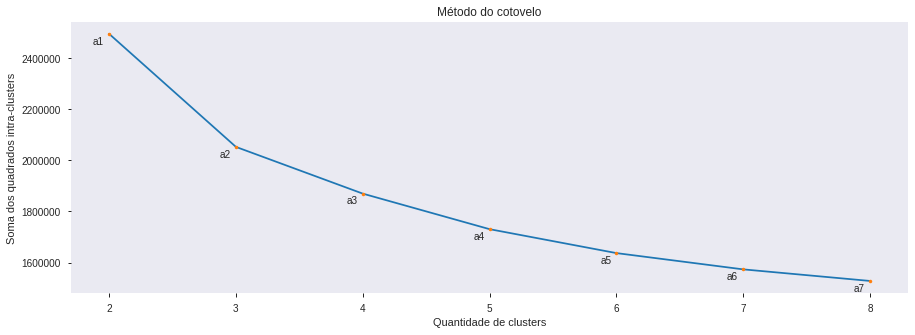

In [148]:
plt.figure(figsize=(15,5))
plt.title('Método do cotovelo')
plt.xlabel('Quantidade de clusters')
plt.ylabel('Soma dos quadrados intra-clusters')
plt.grid()
plt.xticks(intervalo)
plt.plot(intervalo, sum_of_squares) 
plt.plot(intervalo, sum_of_squares, '.') 
for x,y in zip(intervalo, sum_of_squares): 
    label = "a{}".format(x-1)
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(-5,-10),
                 ha='right')
plt.show()

Neste gráfico, não temos muito bem definido a "dobra do cotovelo". Assim optamos por utilizar um método que indica o ponto de equilíbrio entre maior homogeneidade dentro do cluster e a maior diferença entre clusters, é o ponto da curva mais distante de uma reta traçada no gráfico

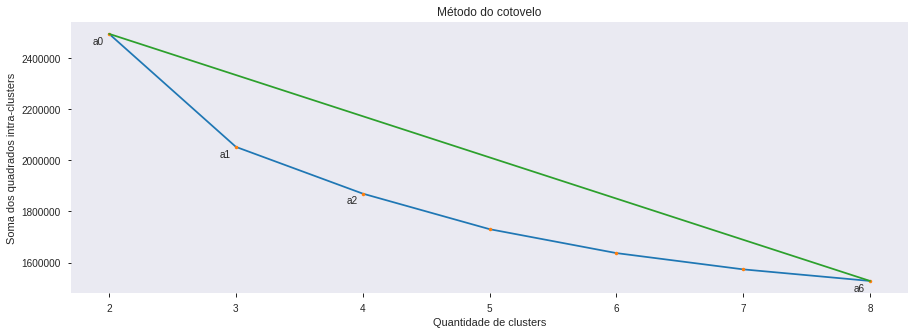

In [149]:
plt.figure(figsize=(15,5))
plt.title('Método do cotovelo')
plt.xlabel('Quantidade de clusters')
plt.ylabel('Soma dos quadrados intra-clusters')
plt.grid()
plt.xticks(intervalo)
plt.plot(intervalo, sum_of_squares)      # pontos laranjas
plt.plot(intervalo, sum_of_squares, '.') # linha azul

y2 = sum_of_squares[len(sum_of_squares)-1]
y1 = sum_of_squares[0]

plt.plot([x2, x1], [y2,y1])                   # linha verde
for x,y in zip(intervalo,sum_of_squares):   # colocando nome nos pontos
    label = "a{}".format(x-2)
    if label in ['a0', 'a1', 'a2', 'a6']:
        plt.annotate(label,
                     (x,y),
                     textcoords="offset points",
                     xytext=(-5,-10),
                     ha='right')
plt.show()

In [150]:
def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 8, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [151]:
n = optimal_number_of_clusters(sum_of_squares)
n

4

In [152]:
kmeans = KMeans(n_clusters=n, random_state=42) # garantindo reprodutibilidade
cl = kmeans.fit(X)

## Visualização dos _clusters_

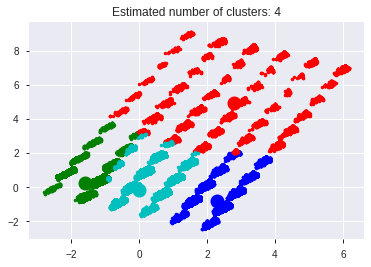

In [153]:
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(len(np.unique(cl.labels_))), colors):
    my_members = cl.labels_ == k
    cluster_center = cl.cluster_centers_[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % len(np.unique(cl.labels_)))
plt.show()

# Análise dos resultados e Apresentação das análises e resultados

## Distribuição dos _clusters_ no mercado

Text(0.5, 1.0, 'clusters')

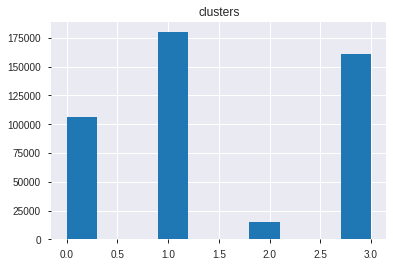

In [154]:
df_mkt_clusters = pd.DataFrame(df_mkt_encoded.index)
df_mkt_clusters['clusters'] = cl.labels_

plt.hist(df_mkt_clusters['clusters'])
plt.title('clusters')

In [155]:
df_mkt_clusters.head()

,id,clusters
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,3
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,1
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,3
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,3
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,1


# Predição

## Portifólio 1

### Entrando com o CSV

In [156]:
df_portfolio_1 = pd.read_csv('../data/estaticos_portfolio1.csv')

### Mapeando os _clusters_ das empresas do portifolio

  - Nesta etapa vamos:
      - Mapear os _clusters_ do portifolio para saber em quais _clusters_ as empresas do portifolio pertencem
      - Remover as empresas do portfolio do mercado
      - Apresentar a distribuição das empresas pelos _clusters_ encontrados

Text(0.5, 1.0, 'clusters')

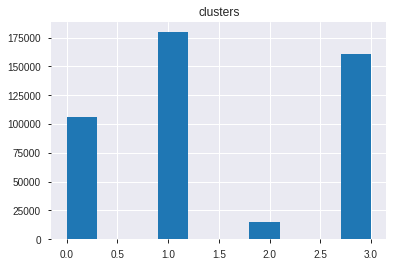

In [157]:
df_clusters_portfolio_1 = pd.merge(df_portfolio_1, df_mkt_clusters, on='id', how='left')
df_mkt_without_portfolio_1 = pd.concat([df_clusters_portfolio_1[['id', 'clusters']], df_mkt_clusters]).drop_duplicates(keep=False)

plt.hist(df_mkt_without_portfolio_1['clusters'])
plt.title('clusters')

In [158]:
df_clusters_values = pd.DataFrame(df_clusters_portfolio_1['clusters'].value_counts(normalize=True))
df_clusters_values

,clusters
1,0.372973
3,0.347748
0,0.255856
2,0.023423


 - Podemos ver que a maioria das empresas do portifolio se encontram no _cluster_ 1, contudo a porcentagem está bem próxima do _cluster_ 3. Assim, vamos apresentar uma lista ordenada para o cliente com as empresas com maior probabilidade de aderência baseado na porcentagem de clientes em cada _cluster_

In [159]:
ordered_clusters_by_prob = list(df_clusters_values.T.columns)

df_mkt_without_portfolio_1.set_index('clusters', inplace=True)
recomendation_list_port_1 = df_mkt_without_portfolio_1.loc[ordered_clusters_by_prob]
recomendation_list_port_1

,id
clusters,
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...
1,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...
1,0114fd3fbdc347c561843cde6aece12e8e53cb5d32c77d...
1,1e954ad5e6a5b7af8582da953709cd702a2f5e5d674361...
1,b0ab88c6ae5e0846f0b8bd63b8472e9ecb73edf9188ff1...
1,82aa41448d40afef92908fdfaa7070b2eedb2ffacb1016...
1,9907170763d88708043f32bc265fbf544d69f966052920...
1,efdae0635be4d9b35bfa6292615edc7c103a22317e788a...
1,91e260a5a74fc61f90280da08eb356e4d74f913eac7780...


## Portifolio 2

### Entrando com o CSV

In [160]:
df_portfolio_2 = pd.read_csv('../data/estaticos_portfolio2.csv')

### Mapeando os _clusters_ das empresas do portifolio

Text(0.5, 1.0, 'clusters')

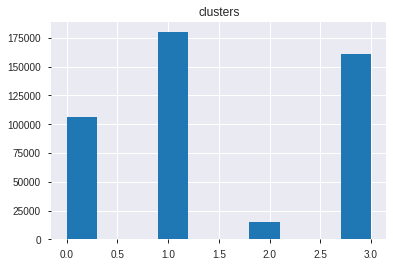

In [161]:
df_clusters_portfolio_2 = pd.merge(df_portfolio_2, df_mkt_clusters, on='id', how='left')
df_mkt_without_portfolio_2 = pd.concat([df_clusters_portfolio_2[['id', 'clusters']], df_mkt_clusters]).drop_duplicates(keep=False)

plt.hist(df_mkt_without_portfolio_2['clusters'])
plt.title('clusters')

In [162]:
df_clusters_values = pd.DataFrame(df_clusters_portfolio_2['clusters'].value_counts(normalize=True))
df_clusters_values

,clusters
2,1.0


 - Podemos ver que todas as empresas do portifolio se encontram no _cluster_ 2. Assim, vamos recomendar para o cliente as empresas que não são clientes ainda que se encontram no _cluster_ 2.

In [163]:
ordered_clusters_by_prob = list(df_clusters_values.T.columns)

df_mkt_without_portfolio_2.set_index('clusters', inplace=True)
recomendation_list_port_2 = df_mkt_without_portfolio_2.loc[ordered_clusters_by_prob]
recomendation_list_port_2

,id
clusters,
2,474c4d2ec42aaa7feaacb73a0eec10516c9fae98919c84...
2,8a584390e7b2fba5ef33a51b2f8fd63bd202194db3e5ee...
2,c5e70d47fe82cf519287e51c21d9557f821c74dde25eb2...
2,6e292487550f4b68a5a710b1512039761b07cdb9d11257...
2,a9cece60e4d8013dfc0f334077d9514459b22afc3f6c0f...
2,f7b060e35a228c6eb962d26c6673f6c984982c6de0e44e...
2,2b3bcf92d3ebd1860cbebd53aa9b25a48341b49ed4a920...
2,3d5ffadc9cebcd0e2df9fe861540d7e76ba7d189e726e6...
2,e87914f6a5bff16f047712eacc06de654caac9f8792dc2...


### Portifolio 3

### Entrando com o CSV

In [164]:
df_portfolio_3 = pd.read_csv('../data/estaticos_portfolio3.csv')

### Mapeando os _clusters_ das empresas do portifolio

Text(0.5, 1.0, 'clusters')

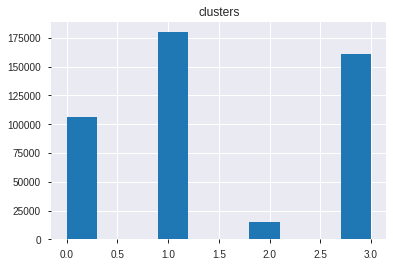

In [165]:
df_clusters_portfolio_3 = pd.merge(df_portfolio_3, df_mkt_clusters, on='id', how='left')
df_mkt_without_portfolio_3 = pd.concat([df_clusters_portfolio_3[['id', 'clusters']], df_mkt_clusters]).drop_duplicates(keep=False)

plt.hist(df_mkt_without_portfolio_3['clusters'])
plt.title('clusters')

In [166]:
df_clusters_values = pd.DataFrame(df_clusters_portfolio_3['clusters'].value_counts(normalize=True))
df_clusters_values

,clusters
2,1.0


 - Podemos ver que todas as empresas do portifolio se encontram no _cluster_ 2. Assim, vamos recomendar para o cliente as empresas que não são clientes ainda que se encontram no _cluster_ 2.

In [167]:
ordered_clusters_by_prob = list(df_clusters_values.T.columns)

df_mkt_without_portfolio_3.set_index('clusters', inplace=True)
recomendation_list_port_3 = df_mkt_without_portfolio_3.loc[ordered_clusters_by_prob]
recomendation_list_port_3

,id
clusters,
2,474c4d2ec42aaa7feaacb73a0eec10516c9fae98919c84...
2,8a584390e7b2fba5ef33a51b2f8fd63bd202194db3e5ee...
2,c5e70d47fe82cf519287e51c21d9557f821c74dde25eb2...
2,6e292487550f4b68a5a710b1512039761b07cdb9d11257...
2,a9cece60e4d8013dfc0f334077d9514459b22afc3f6c0f...
2,f7b060e35a228c6eb962d26c6673f6c984982c6de0e44e...
2,2b3bcf92d3ebd1860cbebd53aa9b25a48341b49ed4a920...
2,3d5ffadc9cebcd0e2df9fe861540d7e76ba7d189e726e6...
2,e87914f6a5bff16f047712eacc06de654caac9f8792dc2...
